# Selective Logging Detection with Deep Learning and GEE

## Contenido

1. [Obtención de datos](#1.-Obtención-de-datos)
2. [Visualización de datos](#2.-Visualización-de-datos)
3. [Procesamiento de datos](#3.-Procesamiento-de-datos)  
    3.1 [Definición de variables](#3.1-Definición-de-variables)  
    3.2 [Crear TFRecordDataset](#3.2-Crear-TFRecordDataset)
4. [Deep Learning](#4.-Deep-Learning)  
    4.1 [Construcción del modelo](#4.1-Construcción-del-modelo)  
    4.2 [Entrenamiento del modelo](#4.2-Entrenamiento-del-modelo)  
    4.3 [Evaluación del modelo](#4.3-Evaluación-del-modelo)  
    4.4 [Guardar el modelo](#4.4-Guardar-el-modelo)  
5. [Transformar el modelo a GEE](#5.-Transformar-el-modelo-a-GEE)

---

## 1. Obtención de datos

Al igual que el notebook anterior, autorizamos a Google Colab a que opere el Google Cloud Storage. 

In [ ]:
from google.colab import auth
auth.authenticate_user()

Verificamos el acceso a nuestro bucket del Google Cloud Storage.

In [2]:
project_id = 'deeplearning-306718'
!gcloud config set project {project_id}
!gsutil ls

gs://colaboraton-logging/
gs://logging-dataset/
gs://logging-roads-dataset/
gs://mining-infrastructure-dataset/
gs://modis-suomi/
gs://nicfi/
gs://rtc-asf/
gs://s5p/
gs://skysat-acca/


Updated property [core/project].


Crearemos una carpeta donde almacenaremos los datos.

In [ ]:
!mkdir logging_dataset

Con los siguientes comandos estaremos copiando los datos subidos del Google Cloud Storage a nuestra computadora local.  
Utilizar la opción `-m` permite realizar esta operación de manera multiparalela, es decir, agilizamos la descarga de numerosos archivos.

In [2]:
!gsutil -m cp gs://colaboraton-logging/*.gz logging_dataset

También importaremos algunas librerías que contribuirán con el entrenamiento del modelo. Este notebook utilizará la versión 2.9.0 de tensorflow.

In [3]:
!pip install tensorflow==2.9
import tensorflow as tf
print(tf.__version__)

gs://colaboraton-logging/
gs://logging-dataset/
gs://logging-roads-dataset/
gs://mining-infrastructure-dataset/
gs://modis-suomi/
gs://nicfi/
gs://rtc-asf/
gs://s5p/
gs://skysat-acca/
2.9.2


Numpy es otra librería importante, que utiliza también TensorFlow, que permite realizar operaciones con tensores y matrices.  
Esta librería también será importada.

In [4]:
import numpy as np

Utilizaremos también matplotlib, para la visualización de los datos.

In [5]:
import matplotlib.pyplot as plt

[Volver al contenido](#Contenido)

---

## 2. Visualización de datos

Empezaremos visualizando un solo archivo TFRecord, si exploramos la carpeta donde se descargaron los archivos, podremos ver que están "comprimidos" con un formato especial `.gz`, Tensorflow permite la utilización de este formato especial, sin la necesidad de descomprimir los archivos.  
Empezaremos creando una variable llamada record, que incluirá en un contenedor `tf.data.TFRecordDataset` la ruta de un archivo exportado.

In [6]:
record = tf.data.TFRecordDataset('logging_dataset/testing_0.tfrecord.gz', compression_type = 'GZIP')
print(record)

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


Podemos ver que los TFRecordDataset no muestran la totalidad de la información, no podemos saber la forma (shape) de los tensores, pese a que sabemos en base al código anterior, que tienen una forma de 64x64.  
Tampoco podemos saber el dtype (el tipo de datos) ni la cantidad de elementos que tiene nuestro TFRecordDataset.

Debido a que los TFRecord son archivos de almacenamiento de tipo binario, debemos transformarlos a una estructura leíble, para ello crearemos un diccionario que contenga las bandas que exportamos en el código anterior y asignamos a cada banda una forma con `tf.io.FixedLenFeature` y un tipo de datos.

In [7]:
features = {
    'b1_normalized': tf.io.FixedLenFeature([64, 64], tf.float32),
    'b2_normalized': tf.io.FixedLenFeature([64, 64], tf.float32),
    'b3_normalized': tf.io.FixedLenFeature([64, 64], tf.float32),
    'b4_normalized': tf.io.FixedLenFeature([64, 64], tf.float32),
    'ndvi': tf.io.FixedLenFeature([64, 64], tf.float32),
    'class': tf.io.FixedLenFeature([64, 64], tf.float32),
}

Crearemos una función para leer un ejemplo serializado en la estructura definida por el diccionario creado anteriormente.

In [8]:
def parse_tfrecord(example_proto):
    return tf.io.parse_single_example(example_proto, features)

Aplicaremos la función recientemente creada a nuestro TFRecordDataset utilizando la función `map`, que permite iterar a través de cada elemento de nuestro TFRecordDataset.

In [9]:
serialized = record.map(parse_tfrecord)
print(serialized)

<MapDataset element_spec={'b1_normalized': TensorSpec(shape=(64, 64), dtype=tf.float32, name=None), 'b2_normalized': TensorSpec(shape=(64, 64), dtype=tf.float32, name=None), 'b3_normalized': TensorSpec(shape=(64, 64), dtype=tf.float32, name=None), 'b4_normalized': TensorSpec(shape=(64, 64), dtype=tf.float32, name=None), 'class': TensorSpec(shape=(64, 64), dtype=tf.float32, name=None), 'ndvi': TensorSpec(shape=(64, 64), dtype=tf.float32, name=None)}>


Podemos visualizar que el objeto creado tiene una forma diferente al TFRecordDataset, ahora vemos que tiene la estructura definida por el diccionario creado.  
Para poder visualizar de manera numérica los valores exportados de las bandas, emplearemos la función `get_single_element`

In [10]:
element = serialized.get_single_element()
print(element)

{'b1_normalized': <tf.Tensor: shape=(64, 64), dtype=float32, numpy=
array([[0.1370446 , 0.13517739, 0.13335359, ..., 0.13517739, 0.13517739,
        0.13148639],
       [0.13517739, 0.13148639, 0.12961918, ..., 0.13886838, 0.1407356 ,
        0.1370446 ],
       [0.1370446 , 0.13517739, 0.12779538, ..., 0.1370446 , 0.13886838,
        0.1370446 ],
       ...,
       [0.13148639, 0.13148639, 0.13335359, ..., 0.13148639, 0.13335359,
        0.1370446 ],
       [0.13335359, 0.13335359, 0.13148639, ..., 0.13148639, 0.13335359,
        0.13517739],
       [0.13335359, 0.13148639, 0.12961918, ..., 0.12961918, 0.13148639,
        0.13148639]], dtype=float32)>, 'b2_normalized': <tf.Tensor: shape=(64, 64), dtype=float32, numpy=
array([[0.10117366, 0.09922802, 0.09922802, ..., 0.10117366, 0.09734514,
        0.09539948],
       [0.10493943, 0.10117366, 0.09734514, ..., 0.11071362, 0.10305655,
        0.09157095],
       [0.10117366, 0.10117366, 0.09734514, ..., 0.1125965 , 0.10493943,
        0.

Tenemos como resultado un diccionario, del cual podemos extraer cada banda utilizando `get` seguido del `key`, que en este caso es el nombre de la banda exportada.

In [11]:
b1 = element.get('b1_normalized')
b2 = element.get('b2_normalized')
b3 = element.get('b3_normalized')
ndvi = element.get('ndvi')
label = element.get('class')

Ahora podemos visualizar los valores numéricos de cualquier banda exportada. También podemos transformar los objetos a un arreglo numpy utilizando la función `numpy`

In [12]:
print(ndvi)

tf.Tensor(
[[0.5430956  0.55374616 0.5635257  ... 0.6101409  0.6017226  0.59791124]
 [0.52087057 0.53300506 0.54323727 ... 0.6009965  0.59905696 0.59641844]
 [0.49617705 0.5121102  0.52646065 ... 0.58543915 0.5864059  0.58951575]
 ...
 [0.63002306 0.63002306 0.6372952  ... 0.630684   0.6329409  0.61896455]
 [0.6312265  0.6294065  0.63363326 ... 0.6306139  0.63351774 0.6213941 ]
 [0.6374187  0.6325301  0.630545   ... 0.6312265  0.637742   0.6326631 ]], shape=(64, 64), dtype=float32)


Ahora crearemos una "imagen" para poder visualizarla, concatenando los valores de las bandas creadas, en un solo tensor.

In [13]:
img = tf.constant([b3.numpy(), b2.numpy(), b1.numpy()])
print(img)

tf.Tensor(
[[[0.08270775 0.08114107 0.07800771 ... 0.07487434 0.07330766 0.06710621]
  [0.08734252 0.08427443 0.08114107 ... 0.07957438 0.07487434 0.06710621]
  [0.09047588 0.08734252 0.08270775 ... 0.08427443 0.07800771 0.06710621]
  ...
  [0.07487434 0.07487434 0.07330766 ... 0.07330766 0.07644102 0.08577584]
  [0.07487434 0.07487434 0.07487434 ... 0.07487434 0.07644102 0.08577584]
  [0.07174098 0.07330766 0.07644102 ... 0.07487434 0.07487434 0.08114107]]

 [[0.10117366 0.09922802 0.09922802 ... 0.10117366 0.09734514 0.09539948]
  [0.10493943 0.10117366 0.09734514 ... 0.11071362 0.10305655 0.09157095]
  [0.10117366 0.10117366 0.09734514 ... 0.1125965  0.10493943 0.09539948]
  ...
  [0.10305655 0.10305655 0.10876796 ... 0.12401933 0.12596498 0.12596498]
  [0.10688508 0.10493943 0.10688508 ... 0.12213644 0.12401933 0.12213644]
  [0.10876796 0.10493943 0.10493943 ... 0.12213644 0.12784787 0.12401933]]

 [[0.1370446  0.13517739 0.13335359 ... 0.13517739 0.13517739 0.13148639]
  [0.135177

Si visualizamos la forma del tensor, vemos que tiene la forma de (3, 64, 64), para poder plotearlo debemos transformar la forma a (64, 64, 3). Para ello utilizaremos la función `transpose`

In [14]:
imgRGB = tf.transpose(img, [1, 2, 0])

Ahora plotearemos los resultados empleando la librería matplotlib.

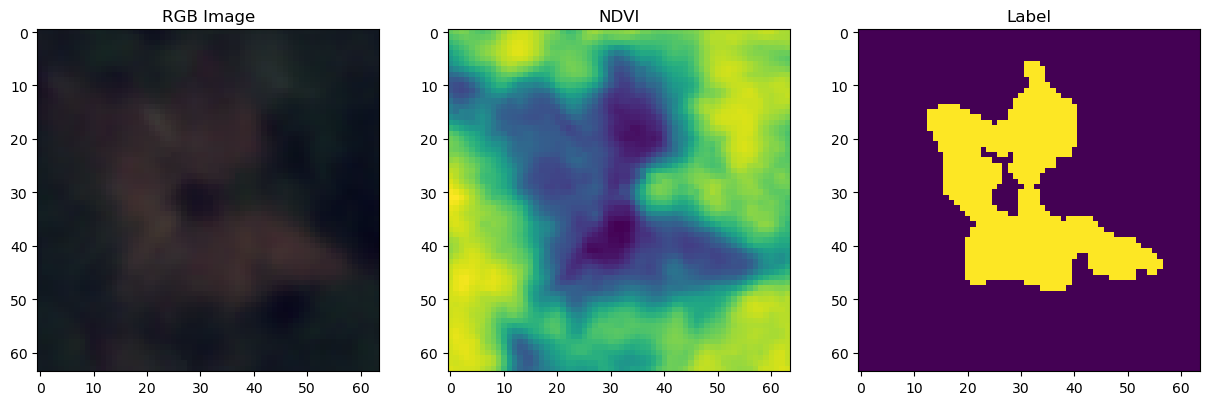

In [15]:
fig, axs = plt.subplots(1, 3, figsize = (15, 15))

axs[0].set_title('RGB Image')
axs[0].imshow(imgRGB)

axs[1].set_title('NDVI')
axs[1].imshow(ndvi.numpy())

axs[2].set_title('Label')
axs[2].imshow(label.numpy())

plt.show()

[Volver al contenido](#Contenido)

---

## 3. Procesamiento de datos

## 3.1 Definición de variables

Antes de realizar el procesamiento de datos, se definirán algunas variables para el entrenamiento.

In [16]:
bands = ['b1_normalized', 'b2_normalized', 'b3_normalized', 'b4_normalized', 'ndvi']
response = ['class']
features = bands + response

kernel_size = 64
kernel_shape = [kernel_size, kernel_size]

columns = [
  tf.io.FixedLenFeature(shape = kernel_shape, dtype = tf.float32) for k in features
]

train_path = 'logging_dataset/train'
val_path = 'logging_dataset/validation'
test_path = 'logging_dataset/testing'

features_dict = dict(zip(features, columns))

train_size = 168
val_size = 48
test_size = 30

batch_size = 1
epochs = 10
buffer_size = 1000

learning_rate = 0.1

## 3.2 Crear TFRecordDataset

Los TFRecordDataset son una colección de TFRecords, por lo que resultan muy útiles para almacenar grandes cantidades de datos, y están optimizados para ahorrar memoria.  
Primero crearemos una función llamada `parse_tfrecord`, que realizará la misma funcionalidad que en la visualización de datos, realizada anteriormente. Transformaremos la estructura de cada TFRecord.

In [17]:
def parse_tfrecord(example_proto):
    return tf.io.parse_single_example(example_proto, features_dict)

Segundo se creará una función llamada `to_tuple`, que convertirá el diccionario de tensores a una tupla, con el esquema de (entradas, salidas).  
Esta función cambiará la forma de los tensores de entrada, cuya dimensionalidad es de (3, 60, 60) a la dimensionalidad de (60, 60, 3)

In [18]:
def to_tuple(inputs):
    inputsList = [inputs.get(key) for key in features]
    stacked = tf.stack(inputsList, axis=0)
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked[:,:,:len(bands)], stacked[:,:,len(bands):]

Tercero se creará una función para leer los tensores, esta función aplicará también las funciones creadas anteriormente: `parse_tfrecord` y `to_tuple`

In [19]:
def get_dataset(pattern):
    glob = tf.io.gfile.glob(pattern)
    dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
    dataset = dataset.map(to_tuple, num_parallel_calls=5)
    return dataset

Crearemos 3 TFRecordDataset, que contendrán a nuestro conjunto de datos de entrenamiento, validación y prueba, respectivamente.  Para ello utilizaremos funciones, dentro de cada una habrá un objeto llamado `glob` que indicará la ruta de los conjuntos de datos.

In [20]:
def get_training_dataset():
    glob = train_path + '*'
    dataset = get_dataset(glob)
    dataset = dataset.shuffle(buffer_size).batch(batch_size).repeat()
    return dataset

training = get_training_dataset()

def get_val_dataset():
    glob = val_path + '*'
    dataset = get_dataset(glob)
    dataset = dataset.batch(1).repeat()
    return dataset

validation = get_val_dataset()

def get_test_dataset():
    glob = test_path + '*'
    dataset = get_dataset(glob)
    dataset = dataset.batch(1)
    return dataset

testing = get_test_dataset()

Si imprimimos los 3 conjuntos de datos veremos que los datos de entrenamiento y de validacion vemos que son de tipo `RepeatDataset`, es decir son archivos que constantemente se vienen generando, que en base a las funciones anteriores van siendo ordenados de manera aleatoria y el conjunto de datos saliente tiene un tamaño de 1 (en base al batch size).

In [21]:
print(training)
print(validation)
print(testing)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 64, 64, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 64, 64, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None))>


[Volver al contenido](#Contenido)

---

## 4. Deep Learning

## 4.1 Construcción del modelo

En el presente notebook utilizaremos la arquitectura de [U-Net](https://arxiv.org/abs/1505.04597), una de las más utilizadas para clasificación. Para ello, utilizaremos algunas capas de `tensorflow.keras`. A continuación la representación gráfica de la arquitectura.
<img src="./pictures/u-net-architecture.png" width=800 alt="U-Net">

In [22]:
def conv_block(input_tensor, num_filters):
    encoder = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = tf.keras.layers.BatchNormalization()(encoder)
    encoder = tf.keras.layers.Activation('relu')(encoder)
    encoder = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = tf.keras.layers.BatchNormalization()(encoder)
    encoder = tf.keras.layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = tf.keras.layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = tf.keras.layers.BatchNormalization()(decoder)
    decoder = tf.keras.layers.Activation('relu')(decoder)
    decoder = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = tf.keras.layers.BatchNormalization()(decoder)
    decoder = tf.keras.layers.Activation('relu')(decoder)
    decoder = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = tf.keras.layers.BatchNormalization()(decoder)
    decoder = tf.keras.layers.Activation('relu')(decoder)
    return decoder

def get_model():
    inputs = tf.keras.Input(shape=[kernel_size, kernel_size, len(bands)])
    encoder0_pool, encoder0 = encoder_block(inputs, 32)
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
    encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
    center = conv_block(encoder4_pool, 1024)
    decoder4 = decoder_block(center, encoder4, 512)
    decoder3 = decoder_block(decoder4, encoder3, 256)
    decoder2 = decoder_block(decoder3, encoder2, 128)
    decoder1 = decoder_block(decoder2, encoder1, 64)
    decoder0 = decoder_block(decoder1, encoder0, 32)
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

Ahora definiremos al modelo, utilizando la función creada `get_model` y compilándolo.

In [23]:
model = get_model()
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), 
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.IoU(num_classes = 2, target_class_ids = [0] , name = 'iou')])

Una vez compilado el modelo, podemos ver las capas que tiene éste utilizando la función `summary`

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 5)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   1472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 64, 64, 32)   0           ['batch_normalization[0][0]']

 max_pooling2d_4 (MaxPooling2D)  (None, 2, 2, 512)   0           ['activation_9[0][0]']           
                                                                                                  
 conv2d_10 (Conv2D)             (None, 2, 2, 1024)   4719616     ['max_pooling2d_4[0][0]']        
                                                                                                  
 batch_normalization_10 (BatchN  (None, 2, 2, 1024)  4096        ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_10 (Activation)     (None, 2, 2, 1024)   0           ['batch_normalization_10[0][0]'] 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 2, 2, 1024)   9438208     ['activation_10[0][0]']          
          

                                                                                                  
 conv2d_17 (Conv2D)             (None, 16, 16, 128)  147584      ['activation_19[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 128)  512        ['conv2d_17[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_20 (Activation)     (None, 16, 16, 128)  0           ['batch_normalization_20[0][0]'] 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 32, 32, 64)  32832       ['activation_20[0][0]']          
 spose)                                                                                           
          

## 4.2 Entrenamiento del modelo

Una vez definido el modelo, procederemos a entrenarlo, ajustándolo al conjunto de datos ya procesado, mediante la función `fit`

In [194]:
history = model.fit(
    x = training, 
    epochs = epochs, 
    verbose = 1,
    steps_per_epoch=int(train_size / batch_size), 
    validation_data = validation,
    validation_steps = val_size)

Epoch 1/10
168/168 [==============================] - 11s 52ms/step - loss: 0.1449 - accuracy: 0.0000e+00 - iou: 0.9240 - val_loss: 0.7870 - val_accuracy: 0.0010 - val_iou: 0.9334
Epoch 2/10
168/168 [==============================] - 8s 48ms/step - loss: 0.1232 - accuracy: 0.0000e+00 - iou: 0.9240 - val_loss: 0.1217 - val_accuracy: 0.0000e+00 - val_iou: 0.9325
Epoch 3/10
168/168 [==============================] - 8s 47ms/step - loss: 0.1160 - accuracy: 0.0000e+00 - iou: 0.9240 - val_loss: 0.1033 - val_accuracy: 0.0000e+00 - val_iou: 0.9325
Epoch 4/10
168/168 [==============================] - 8s 49ms/step - loss: 0.1120 - accuracy: 0.0000e+00 - iou: 0.9240 - val_loss: 0.3004 - val_accuracy: 0.0230 - val_iou: 0.9530
Epoch 5/10
168/168 [==============================] - 8s 49ms/step - loss: 0.1065 - accuracy: 0.0000e+00 - iou: 0.9240 - val_loss: 0.1103 - val_accuracy: 1.8819e-04 - val_iou: 0.9327
Epoch 6/10
168/168 [==============================] - 8s 49ms/step - loss: 0.1022 - accuracy

Podemos plotear los resultados del entrenamienta por época utilizando matplotlib.

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


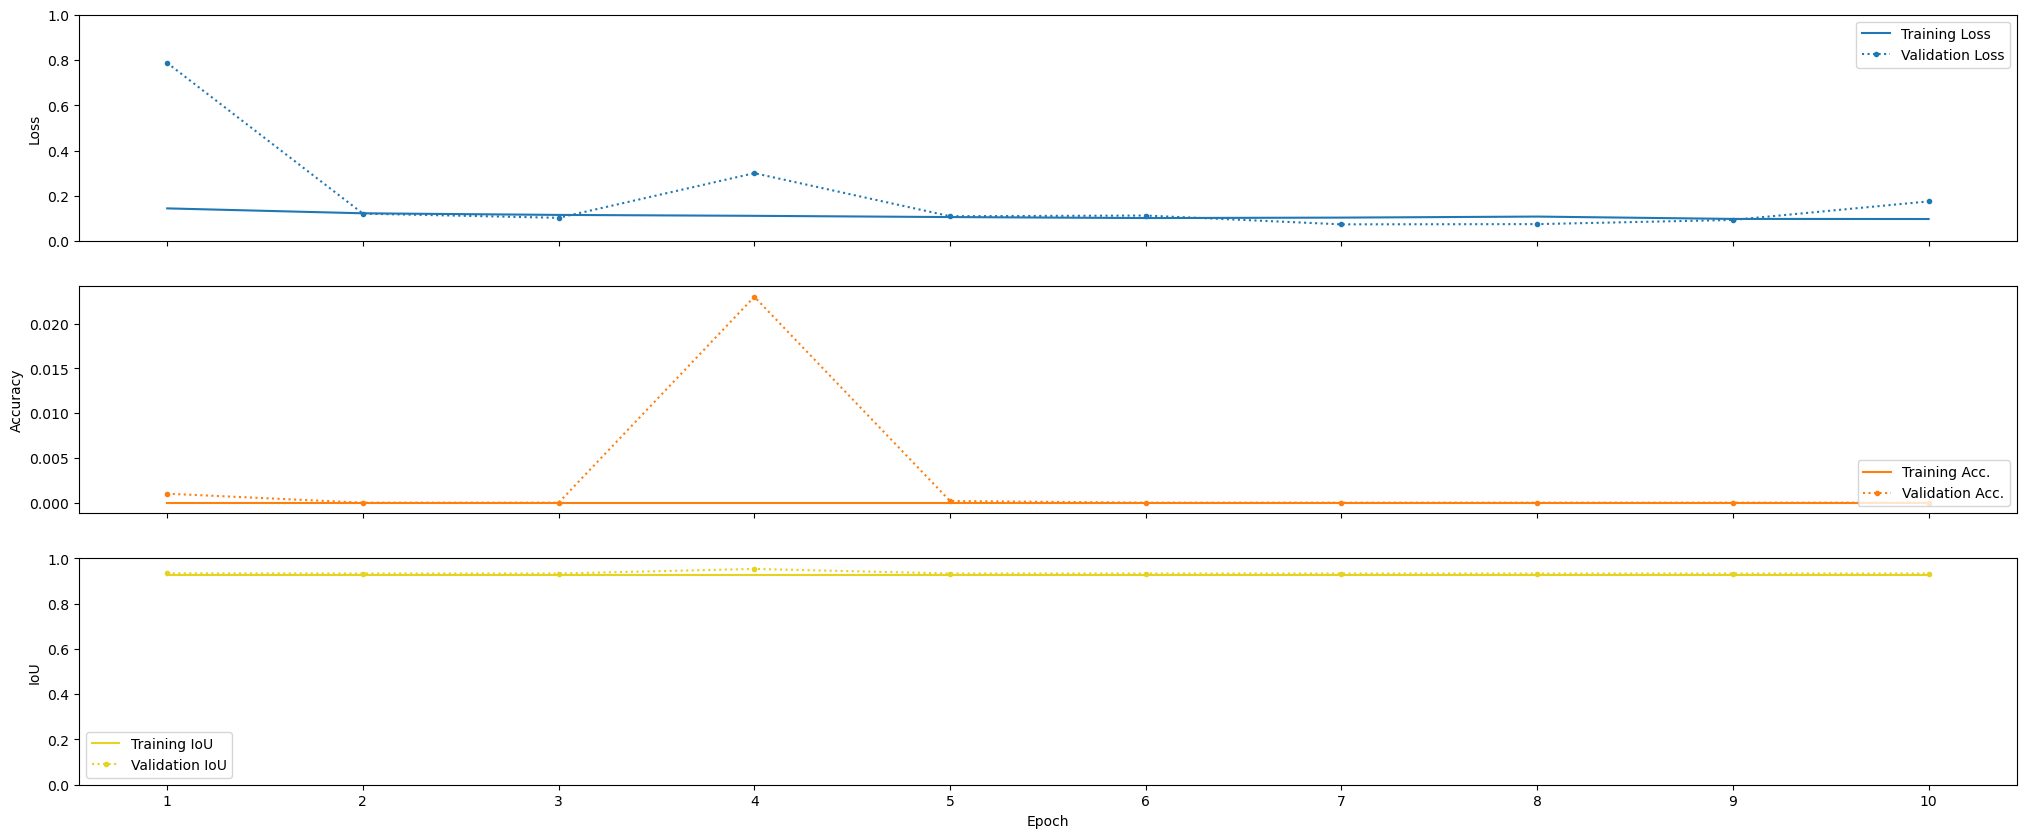

In [197]:
#Gráfico de métricas
%pylab inline
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15,10))

ax[0].plot(history.history['loss'],color='#1f77b4',label='Training Loss')
ax[0].plot(history.history['val_loss'],linestyle=':',marker='o',markersize=3,color='#1f77b4',label='Validation Loss')
ax[0].set_ylabel('Loss')
ax[0].set_ylim(0.0,1)
ax[0].legend()

ax[1].plot(history.history['iou'],color='#E5D31F',label='Training IoU')
ax[1].plot(history.history['val_iou'],linestyle=':',marker='o',markersize=3,color='#E5D31F',label='Validation IoU')
ax[1].set_ylabel('IoU')
ax[1].legend(loc="lower right")

ax[1].set_xticks(history.epoch)
ax[1].set_xticklabels(range(1,len(history.epoch)+1, 1))
ax[1].set_xlabel('Epoch')
ax[1].set_ylim(0.0,1)

plt.legend()

## 4.3 Evaluación del modelo

Ahora utilizaremos los datos de prueba, reservados para este momento. Podemos obtener las métricas totales para todo el conjunto de datos de prueba.

In [199]:
evaluation = model.evaluate(
    x = testing,
    verbose = 1,
    steps = test_size
)

30/30 [==============================] - 1s 21ms/step - loss: 0.1859 - accuracy: 0.0000e+00 - iou: 0.9186


Podemos tambien aplicar el modelo al conjunto de datos de prueba, y graficar los resultados.

In [200]:
prediction = model.predict(
    x = testing,
    verbose = 1,
    steps = test_size
)

30/30 [==============================] - 1s 18ms/step


Corriendo el siguiente bloque de código podemos visualizar 3 imágenes aleatorias de nuestro conjunto de datos de prueba, y las predicciones del modelo.

[1, 25, 4]


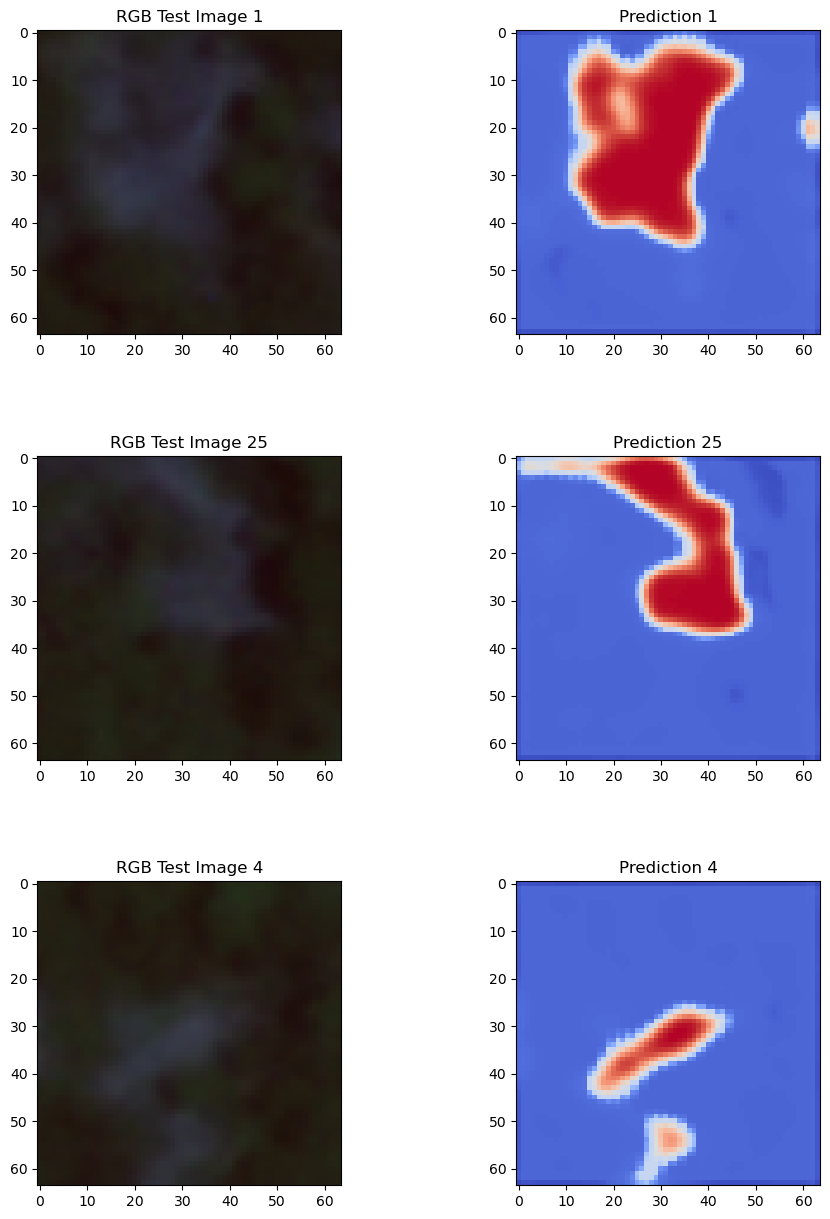

In [418]:
import random
listTest = []
n_images = 3
for i in range(n_images):
    listTest.append(random.randint(0, test_size-1))

print(listTest)

fig, axs = plt.subplots(n_images, 2, figsize = (15, 15))

for i in range(len(listTest)):
    imgTest = tf.squeeze(list(testing)[listTest[i]][0])[:,:,0:3].numpy()
    imgPred = prediction[listTest[i]].reshape(64, 64)
    
    axs[i,0].set_title('RGB Test Image ' + str(listTest[i]))
    axs[i,0].imshow(imgTest)
    axs[i,1].set_title('Prediction ' + str(listTest[i]))
    axs[i,1].imshow(imgPred, cmap = 'coolwarm')

plt.subplots_adjust(wspace=-0.3, hspace=0.4)
plt.show()

## 4.4 Guardar el modelo 

Una vez tengamos un modelo adecuado en base a las métricas utilizadas, procederemos a guardarlo.  
Para ello emplearemos la función `tf.keras.save_model` y tendremos que especificar la ruta para guardar el modelo.

In [25]:
modelDir = 'logging_model'

In [419]:
tf.keras.models.save_model(model, modelDir)

INFO:tensorflow:Assets written to: logging_model\assets


INFO:tensorflow:Assets written to: logging_model\assets


Si lo queremos, podemos cargar el modelo utilizando la función `tf.keras.models.load_model`

In [26]:
loaded_model = tf.keras.models.load_model(modelDir)

Si empleamos la función `summary` podremos ver nuevamente la estructura del modelo guardado.

In [27]:
loaded_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 64, 64, 5)]  0           []                               
                                                                                                  
 conv2d_256 (Conv2D)            (None, 64, 64, 32)   1472        ['input_14[0][0]']               
                                                                                                  
 batch_normalization_299 (Batch  (None, 64, 64, 32)  128         ['conv2d_256[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_299 (Activation)    (None, 64, 64, 32)   0           ['batch_normalization_299[

 Normalization)                                                                                   
                                                                                                  
 activation_308 (Activation)    (None, 4, 4, 512)    0           ['batch_normalization_308[0][0]']
                                                                                                  
 max_pooling2d_59 (MaxPooling2D  (None, 2, 2, 512)   0           ['activation_308[0][0]']         
 )                                                                                                
                                                                                                  
 conv2d_266 (Conv2D)            (None, 2, 2, 1024)   4719616     ['max_pooling2d_59[0][0]']       
                                                                                                  
 batch_normalization_309 (Batch  (None, 2, 2, 1024)  4096        ['conv2d_266[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_318 (Batch  (None, 16, 16, 128)  512        ['conv2d_272[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_318 (Activation)    (None, 16, 16, 128)  0           ['batch_normalization_318[0][0]']
                                                                                                  
 conv2d_273 (Conv2D)            (None, 16, 16, 128)  147584      ['activation_318[0][0]']         
                                                                                                  
 batch_normalization_319 (Batch  (None, 16, 16, 128)  512        ['conv2d_273[0][0]']             
 Normalization)                                                                                   
          

[Volver al contenido](#Contenido)

---

## 5. Transformar el modelo a GEE

Hasta ahora, todo el procesamiento realizado y el entrenamiento, así como las predicciones se han realizado de manera local (en nuestra computadora). Si deseamos aplicar el modelo en regiones amplias o a escenas/imágenes completas lo recomendable es utilizar Google Earth Engine.  
Para realizar esta operación requerimos de acceso a un bucket de Google Cloud Storage, así como saldo disponible para la subida del modelo "eeificado" al módulo **AI Platform** de Google Cloud, desde donde se desplegará el modelo para realizar las predicciones.  
En primer lugar definiremos algunas rutas y guardaremos nuestro modelo en el Google Cloud Platform.

In [28]:
bucket = 'colaboraton-logging'
eeified_dir = '{}/eeified'.format(modelDir)
project = 'deeplearning-306718'

print(modelDir)
print(bucket)
print(eeified_dir)
print(project)

logging_model
colaboraton-logging
logging_model/eeified
deeplearning-306718


Al igual que el código anterior importaremos Earth Engine

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

In [29]:
!earthengine set_project {project}

Successfully saved project id


Utilizando el siguiente comando de gsutil, copiaremos el contenido entero de la carpeta donde está almacenado el modelo al bucket definido previamente.

In [426]:
!gsutil -m cp -r {modelDir} gs://{bucket + '/' + modelDir}

Copying file://logging_model\variables\variables.index [Content-Type=application/octet-stream]...
/ [0/4 files][    0.0 B/358.4 MiB]   0% Done                                    
Copying file://logging_model\keras_metadata.pb [Content-Type=application/octet-stream]...
/ [0/4 files][    0.0 B/358.4 MiB]   0% Done                                    
Copying file://logging_model\saved_model.pb [Content-Type=application/octet-stream]...
/ [0/4 files][    0.0 B/358.4 MiB]   0% Done                                    
Copying file://logging_model\variables\variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/stor

Lo siguiente es importar un módulo de tensorflow, que transformará el modelo a uno apto para ser utilizado en Google Earth Engine.

In [427]:
from tensorflow.python.tools import saved_model_utils

meta_graph_def = saved_model_utils.get_meta_graph_def(modelDir, 'serve')
inputs = meta_graph_def.signature_def['serving_default'].inputs
outputs = meta_graph_def.signature_def['serving_default'].outputs

input_name = None
for k,v in inputs.items():
    input_name = v.name
    break

output_name = None
for k,v in outputs.items():
    output_name = v.name
    break

import json
input_dict = "'" + json.dumps({input_name:"array"}, separators=(',', ':')) + "'"
output_dict = "'" + json.dumps({output_name:"class"}, separators=(',', ':')) + "'"

print(input_dict)
print(output_dict)

'{"serving_default_input_14:0":"array"}'
'{"StatefulPartitionedCall:0":"class"}'


Por último utilizaremos el comando `model prepare` para preparar el modelo.

In [429]:
!earthengine model prepare --source_dir={modelDir} --dest_dir={eeified_dir} --input={input_dict} --output={output_dict}

Traceback (most recent call last):
  File "C:\Users\LENOVO\anaconda3\envs\ai\Scripts\earthengine-script.py", line 9, in <module>
    sys.exit(main())
  File "C:\Users\LENOVO\anaconda3\envs\ai\lib\site-packages\ee\cli\eecli.py", line 80, in main
    tf_module.app.run(_run_command, argv=sys.argv[:1])
  File "C:\Users\LENOVO\anaconda3\envs\ai\lib\site-packages\tensorflow\python\platform\app.py", line 36, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "C:\Users\LENOVO\anaconda3\envs\ai\lib\site-packages\absl\app.py", line 312, in run
    _run_main(main, args)
  File "C:\Users\LENOVO\anaconda3\envs\ai\lib\site-packages\absl\app.py", line 258, in _run_main
    sys.exit(main(argv))
  File "C:\Users\LENOVO\anaconda3\envs\ai\lib\site-packages\ee\cli\eecli.py", line 61, in _run_command
    dispatcher.run(args, config)
  File "C:\Users\LENOVO\anaconda3\envs\ai\lib\site-packages\ee\cli\commands.py", line 355, in run
    self.command_dict[vars(args)[self.dest

En este paso veremos que obtenemos un error, hasta ahora **NO** sabemos la causa del error, creemos que se debe a la diferencia de sistemas operativos. En Google Colab esta línea de código funciona perfectamente.  
El siguiente paso es subir al Google Cloud Storage nuestra carpeta llamada `eeified`. La cual contiene al modelo optimizado para su funcionamiento en la nube.

In [35]:
!gsutil -m cp -r {eeified_dir} {'gs://'+ bucket + '/' + modelDir}

Copying file://logging_model\eeified\variables\variables.index [Content-Type=application/octet-stream]...
/ [0/2 files][    0.0 B/  1.7 MiB]   0% Done                                    
Copying file://logging_model\eeified\saved_model.pb [Content-Type=application/octet-stream]...
/ [0/2 files][    0.0 B/  1.7 MiB]   0% Done                                    
/ [1/2 files][ 26.2 KiB/  1.7 MiB]   1% Done                                    
-
\
\ [2/2 files][  1.7 MiB/  1.7 MiB] 100% Done                                    
|

Operation completed over 2 objects/1.7 MiB.                                      


Por último, dentro del módulo de AI-Platform de Google Cloud Storage crearemos un repositorio donde se almacenará nuestro modelo.

In [36]:
model_name = 'colaboraton_logging'
version_name = 'v1'
print('Creating version: ' + version_name)

!gcloud ai-platform models create {model_name} --project {project}

Creating version: v1


Using endpoint [https://us-central1-ml.googleapis.com/]
Created ai platform model [projects/deeplearning-306718/models/colaboraton_logging].


^C


Subimos el modelo al repositorio recientemente creado.

In [37]:
!gcloud ai-platform versions create {version_name} \
  --project {project} \
  --model {model_name} \
  --origin {'gs://'+ bucket + '/' + eeified_dir} \
  --runtime-version=2.9 \
  --framework "TENSORFLOW" \
  --python-version=3.7

Using endpoint [https://us-central1-ml.googleapis.com/]
ERROR: (gcloud.ai-platform.versions.create) ALREADY_EXISTS: Field: version.name Error: A version with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A version with the same name already exists.
    field: version.name
Using endpoint [https://us-central1-ml.googleapis.com/]
Creating version (this might take a few minutes)......
...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[Volver al contenido](#Contenido)

---